# 5 GLMの尤度比検定と検定の非対称性

In [1]:
using CSV
using Distributions
using GLM
using Plots
using StatsBase
using Statistics

In [2]:
df = CSV.read("data/section3.csv");

### 5.4.1 方法(1) 汎用性のあるパラメトリックブートストラップ法
一定モデル

In [3]:
fit1 = glm(@formula(y ~ 1), df, Poisson())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ +1

Coefficients:
             Estimate Std.Error z value Pr(>|z|)
(Intercept)   2.05796 0.0357371 57.5862   <1e-99


xモデル

In [4]:
fit2 = glm(@formula(y ~ x), df, Poisson())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x

Coefficients:
              Estimate Std.Error z value Pr(>|z|)
(Intercept)    1.29172  0.363686 3.55174   0.0004
x            0.0756619 0.0356042 2.12509   0.0336


### 残差逸脱度の差

In [5]:
deviance(fit1) - deviance(fit2)

4.513941078851829

### 真のモデルから100個体分のデータを新しく生成

In [6]:
df.y_rnd = rand(Poisson(mean(df.y)), 100)

100-element Array{Int64,1}:
 11
  5
 11
  9
  6
  5
 15
  7
  7
  4
  6
  5
  6
  ⋮
 12
 12
  8
 12
  9
  5
  4
  7
  7
  6
 11
 15

### 一定モデルとxモデルをこの真データに当てはめる

In [7]:
fit1 = glm(@formula(y_rnd ~ 1), df, Poisson())
fit2 = glm(@formula(y_rnd ~ x), df, Poisson())
deviance(fit1) - deviance(fit2)

0.6199657989755849

### PB法を実行する関数
データの生成と逸脱度差の評価

In [8]:
function get_dd(df)
    n_samples = size(df, 1)
    y_mean = mean(df.y)
    df.y_rnd = rand(Poisson(y_mean), n_samples)
    fit1 = glm(@formula(y_rnd ~ 1), df, Poisson())
    fit2 = glm(@formula(y_rnd ~ x), df, Poisson())
    deviance(fit1) - deviance(fit2)
end

get_dd (generic function with 1 method)

In [9]:
function pb(df, n_bootstrap)
    [get_dd(df) for _ in 1:n_bootstrap]
end

pb (generic function with 1 method)

### 逸脱度の差のサンプルを1000個を作成

In [10]:
dd12 = pb(df, 1000)

1000-element Array{Float64,1}:
 0.7082661543611266    
 0.516819542908749     
 0.7293315409086034    
 3.116923023972916     
 2.6350390415481115    
 0.4276307000290842    
 0.7922940420734506    
 1.0668739363451039    
 0.00033155593925471294
 0.053889136515508085  
 0.7502523700202772    
 0.3808320207333509    
 0.2783095860459497    
 ⋮                     
 0.012759648353835473  
 0.05097101122959202   
 2.258353695118359     
 0.520335345650011     
 1.7104951344454093    
 4.47999140867644      
 0.8664084715840374    
 0.12647722889860802   
 1.8132508462910693    
 3.9584918785928807    
 0.7147129918776187    
 0.44292301272905377   

In [11]:
describe(dd12)

Summary Stats:
Mean:           0.940905
Minimum:        0.000004
1st Quartile:   0.124611
Median:         0.445153
3rd Quartile:   1.222391
Maximum:        10.225375
Length:         1000
Type:           Float64


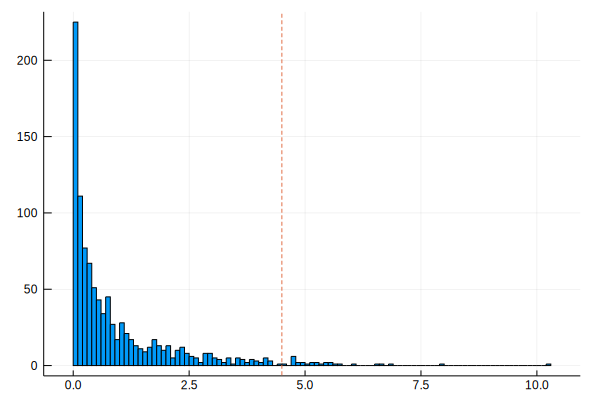

In [12]:
histogram(dd12, bins=100, label="")
plot!([4.5], seriestype=:vline, linestyle=:dash, label="")

合計1000個の$\Delta D_{1,2}$のうちいくつが4.5より右にあるか

In [13]:
sum(dd12 .>= 4.5)

29

$P=0.05$となる逸脱度の差

In [14]:
quantile(dd12, 0.95)

3.6602382244769007

### 方法(2) $\chi^2$分布を使った近似計算法

In [15]:
ccdf(Chisq(1), 4.513)

0.03363819191961954